In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# For Machine Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

root = "tensile_fatigue_data_genel_raw.xlsx"
main_df = pd.read_excel(root)

ANN(6, 0.33, 5, 90000, 0.7, 0.9)

In [3]:
def SNN(h_layer1, h_layer2, h_layer3, graph):
    X = pd.read_excel(root,usecols=[0,1,2,3,4])
    y = pd.read_excel(root,usecols=[6])
    
    # Normalize inputs
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y)
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)
    
    # Define the neural network
    class DeepNN(nn.Module):
        def __init__(self, input_size = 5, output_size = 1):
            super(DeepNN, self).__init__()
            self.fc1 = nn.Linear(input_size, h_layer1)
            self.fc2 = nn.Linear(h_layer1, h_layer2)
            self.fc3 = nn.Linear(h_layer2, h_layer3)
            self.out = nn.Linear(h_layer3, output_size)
    
            self.activation = nn.Sigmoid()  # Logistic sigmoid
    
        def forward(self, x):
            x = self.activation(self.fc1(x))
            x = self.activation(self.fc2(x))
            x = self.activation(self.fc3(x))
            x = self.out(x)
            return x
    
    # Example instantiation
    model = DeepNN()
    
    # Loss function (Mean Squared Error for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    
    num_epochs = 1000
    mse_train = []
    mse_test  = []

    mape_train = []
    mape_test  = []

    max_r2_test = []
    
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        y_train_pred = model(X_train)
        y_test_pred = model(X_test)
        loss = criterion(y_train_pred, y_train)

        # Inverse from normalize
        y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
        y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
        y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
        y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

        # MAPE Calculation
        mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
        mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

        mape_train.append(mape_train_epoch)
        mape_test.append(mape_test_epoch)

        # Obtain Minimum MSE
        min_mape_train_x = np.argmin(mape_train)
        min_mape_train_y = np.min(mape_train)
        min_mape_test_x = np.argmin(mape_test)
        min_mape_test_y = np.min(mape_test)

        max_mape_train_y = np.max(mape_train)
        max_mape_test_y = np.max(mape_test)

        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
        max_r2_test.append(var_test)
        max_r2_test_score = np.max(max_r2_test)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
        var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    
        if (epoch+1) % 100 == 0 & graph == True:
            print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
            print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
            print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
            
            fig, axes = plt.subplots(1, 2, figsize = (8,3))
            axes[0].scatter(y_train_r, y_train_pred_r)
            axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
            axes[0].set_title("Training Data")
            axes[0].set_xlabel("Actual values")
            axes[0].set_ylabel("Predicted values")
    
            axes[1].scatter(y_test_r, y_test_pred_r)
            axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
            axes[1].set_title("Test Data")
            axes[1].set_xlabel("Actual values")
            axes[1].set_ylabel("Predicted values")
            
            f = plt.figure(figsize=(8,5))
            plt.plot(mape_train, label = "Train MAPE")
            plt.plot(mape_test , label = "Test MAPE")
            plt.ylabel("Mean Absolute Percentage Error (%)")
            plt.xlabel("Epoch")
            plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
            plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
            plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
                     bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
            plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
                     bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
            plt.legend()
    
            plt.draw();plt.pause(0.05)
        
        plt.ioff()
        plt.show()

    return max_r2_test_score

HL 1: 7 HL 2: 10 HL 3: 16  Max R2:  0.5223077709956458
HL 1: 7 HL 2: 10 HL 3: 17  Max R2:  0.5432746852108203
HL 1: 7 HL 2: 10 HL 3: 18  Max R2:  0.5005492924570716
HL 1: 7 HL 2: 11 HL 3: 16  Max R2:  0.39062075489703507
HL 1: 7 HL 2: 11 HL 3: 17  Max R2:  0.6990063227506034
HL 1: 7 HL 2: 11 HL 3: 18  Max R2:  0.35926316127794444
HL 1: 7 HL 2: 12 HL 3: 16  Max R2:  0.5984354511342919
HL 1: 7 HL 2: 12 HL 3: 17  Max R2:  0.4260183400437011
HL 1: 7 HL 2: 12 HL 3: 18  Max R2:  0.5798979257795494
HL 1: 8 HL 2: 10 HL 3: 16  Max R2:  0.6583816560165174
HL 1: 8 HL 2: 10 HL 3: 17  Max R2:  0.48680713742635684
HL 1: 8 HL 2: 10 HL 3: 18  Max R2:  0.45283744666348846
HL 1: 8 HL 2: 11 HL 3: 16  Max R2:  0.49421789819733386
HL 1: 8 HL 2: 11 HL 3: 17  Max R2:  0.6346181647923839
HL 1: 8 HL 2: 11 HL 3: 18  Max R2:  0.5685863050676248
HL 1: 8 HL 2: 12 HL 3: 16  Max R2:  0.7106751854999183
HL 1: 8 HL 2: 12 HL 3: 17  Max R2:  0.5413706009059459
HL 1: 8 HL 2: 12 HL 3: 18  Max R2:  0.416274379875577


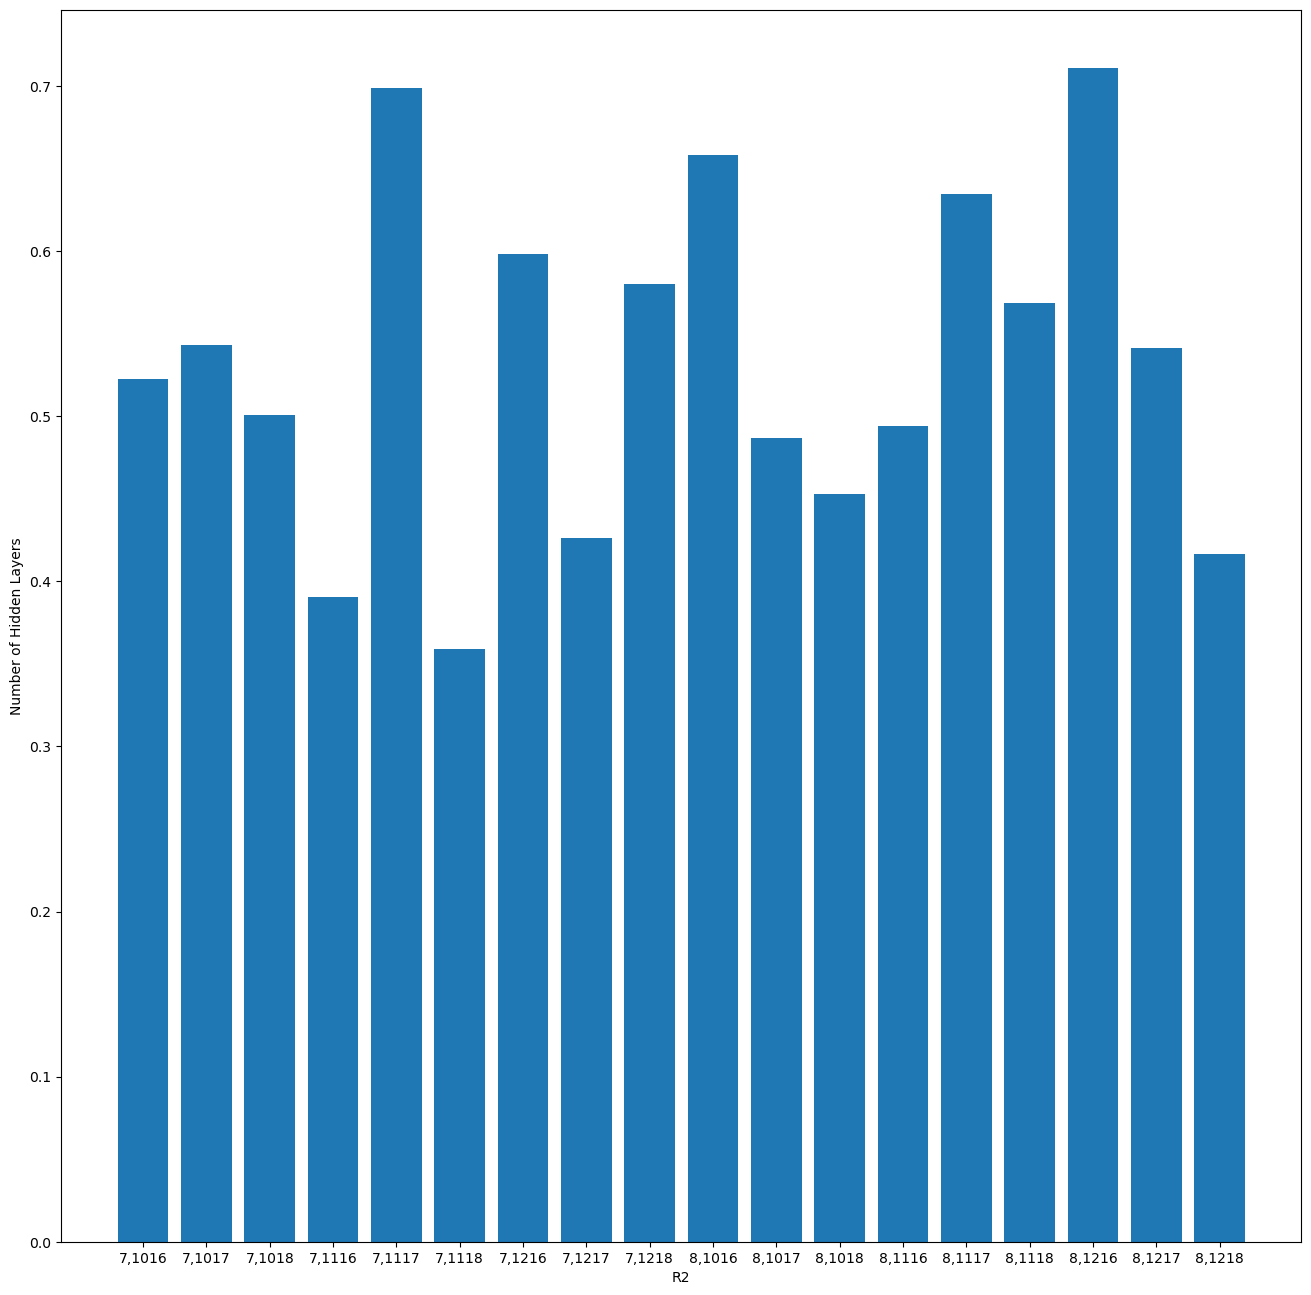

In [11]:
test2 = []
test3 = []

for x in range(7, 9,1):
    for y in range(10, 13,1):
        for z in range(16, 19, 1):
            result = SNN(x, y, z, False)
            print("HL 1:", x, "HL 2:", y, "HL 3:", z," Max R2: ", result)
            hlayer_str = f"{x}" + "," + f"{y}" + f"{z}"
            test2.append(result)
            test3.append(hlayer_str)

f = plt.figure(figsize=(16,16))
x_bar = np.array(test3)
y_bar = np.array(test2)

plt.bar(x_bar,y_bar)
plt.xlabel("R2")
plt.ylabel("Number of Hidden Layers")
plt.show()

## Troubleshoot

8, 12 ,16

Epoch 100/1000
Train R²:  0.20906   Train MAPE:  14.109660685062408
Test R² :  0.34145   Test MAPE:   13.766077160835266


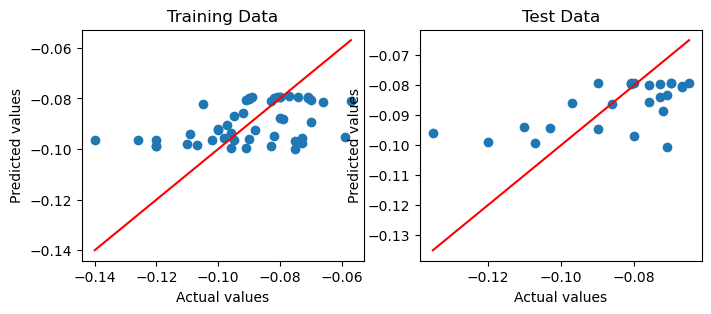

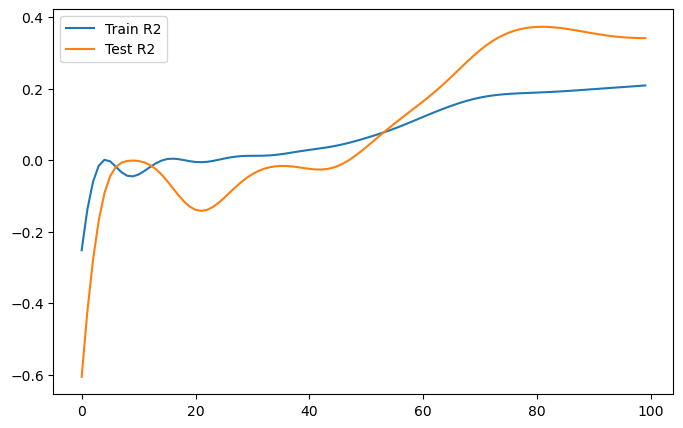

Epoch 200/1000
Train R²:  0.59613   Train MAPE:  10.372380167245865
Test R² :  0.38087   Test MAPE:   11.67074739933014


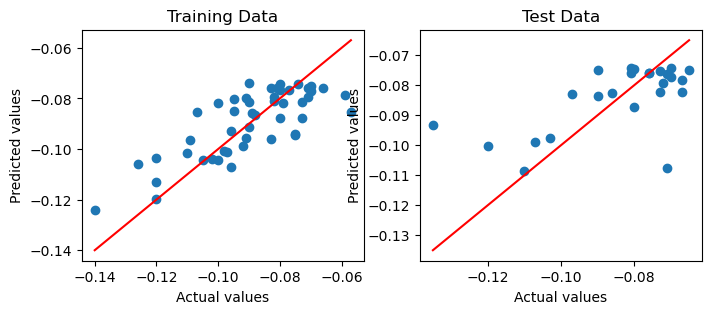

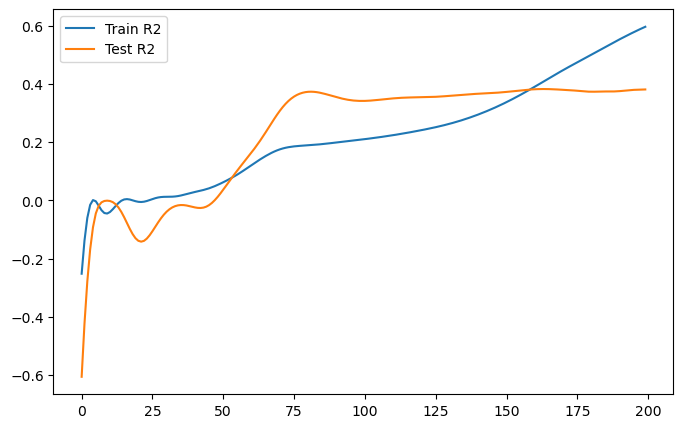

Epoch 300/1000
Train R²:  0.74029   Train MAPE:  7.879387587308884
Test R² :  0.41308   Test MAPE:   11.652574688196182


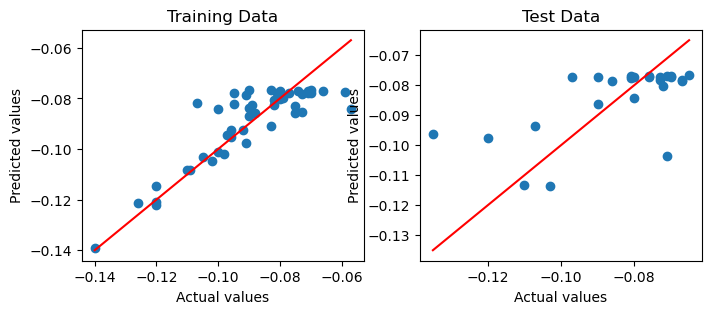

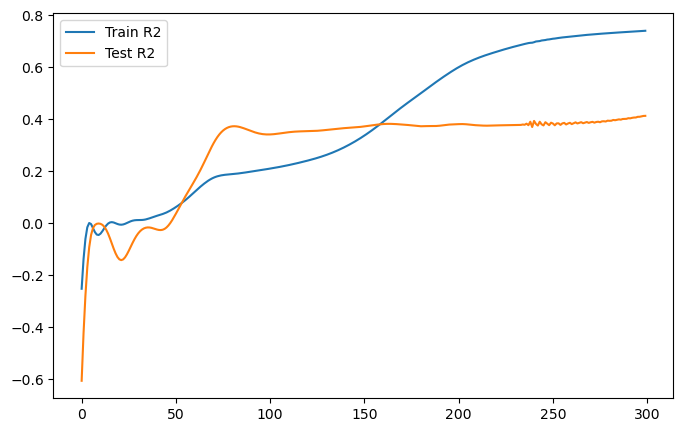

Epoch 400/1000
Train R²:  0.78056   Train MAPE:  7.002680748701096
Test R² :  0.53332   Test MAPE:   10.513177514076233


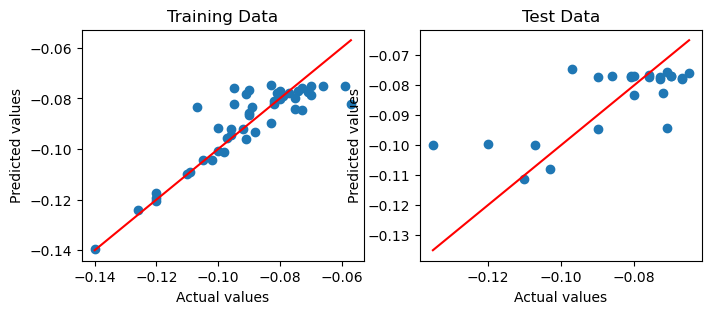

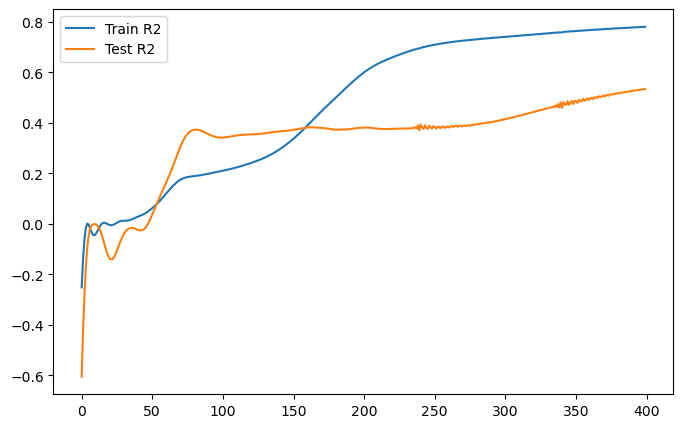

Epoch 500/1000
Train R²:  0.80448   Train MAPE:  6.336104869842529
Test R² :  0.55388   Test MAPE:   10.646326094865799


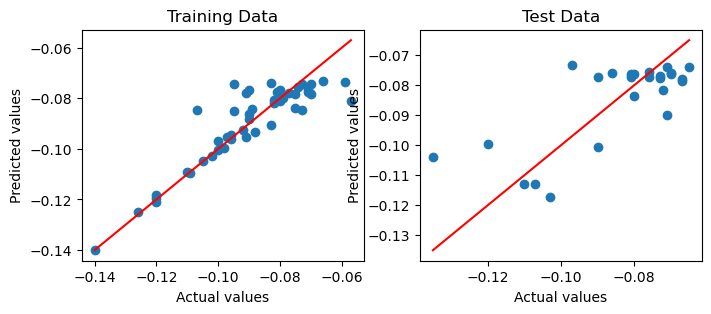

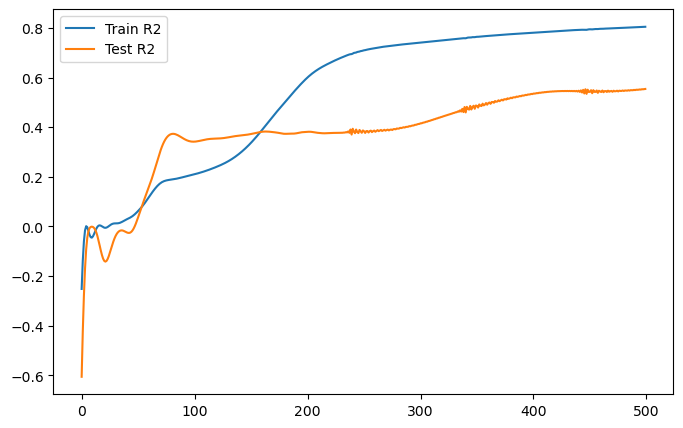

Epoch 600/1000
Train R²:  0.83511   Train MAPE:  5.7692378759384155
Test R² :  0.58989   Test MAPE:   10.496194660663605


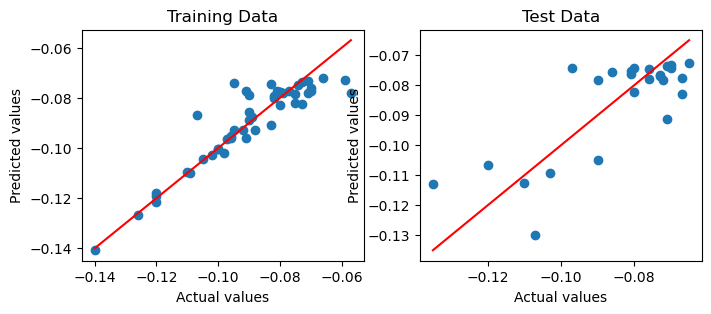

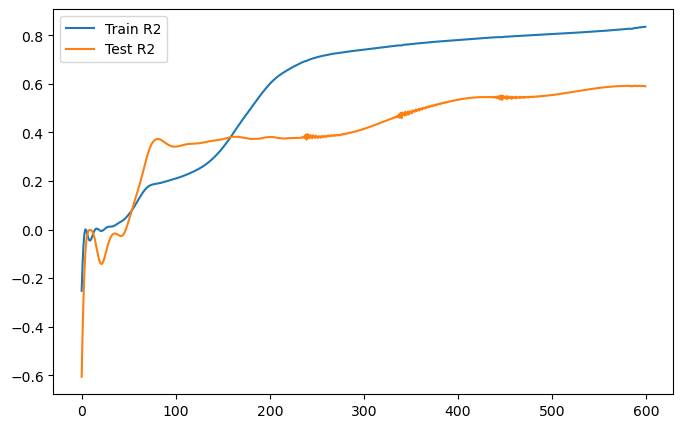

Epoch 700/1000
Train R²:  0.89126   Train MAPE:  4.6846020966768265
Test R² :  0.54078   Test MAPE:   10.315866768360138


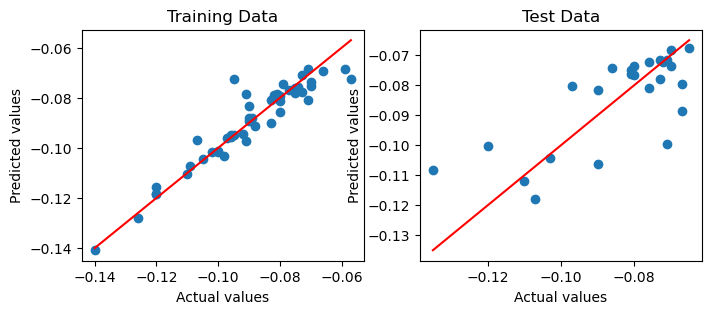

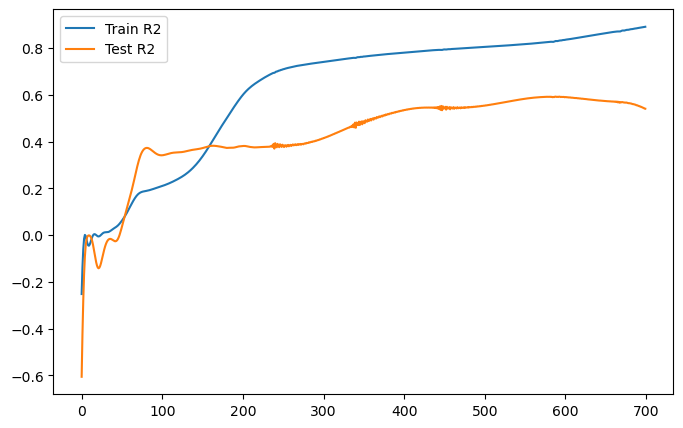

Epoch 800/1000
Train R²:  0.93129   Train MAPE:  3.55323888361454
Test R² :  0.39619   Test MAPE:   11.126518249511719


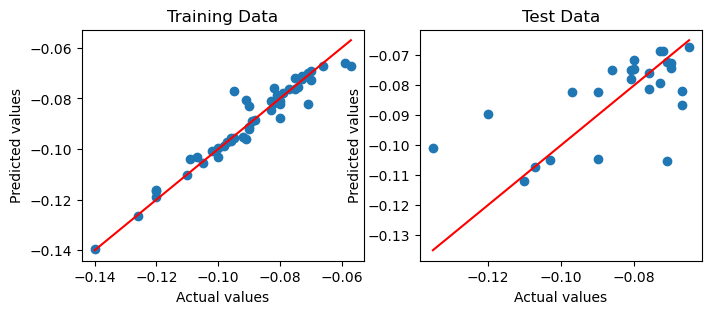

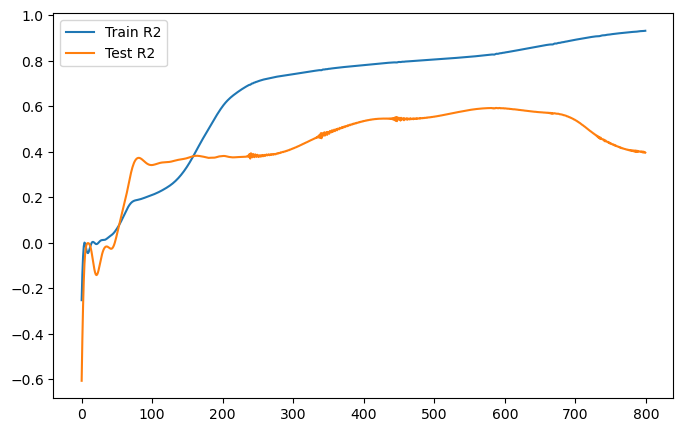

Epoch 900/1000
Train R²:  0.95871   Train MAPE:  2.8365105390548706
Test R² :  0.32225   Test MAPE:   12.307660281658173


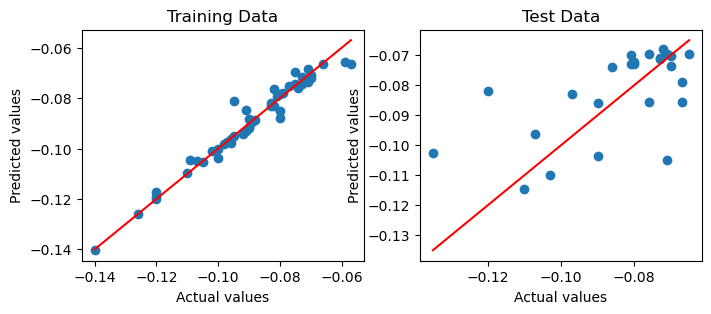

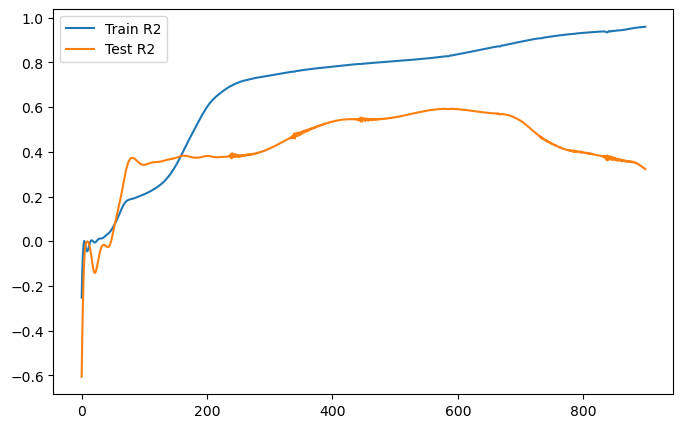

Epoch 1000/1000
Train R²:  0.97484   Train MAPE:  2.1026963368058205
Test R² :  0.23077   Test MAPE:   14.081329107284546


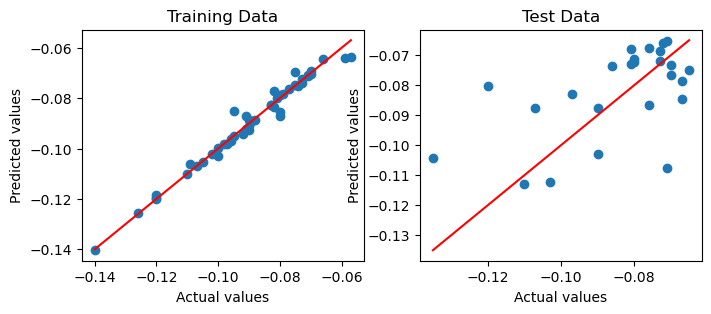

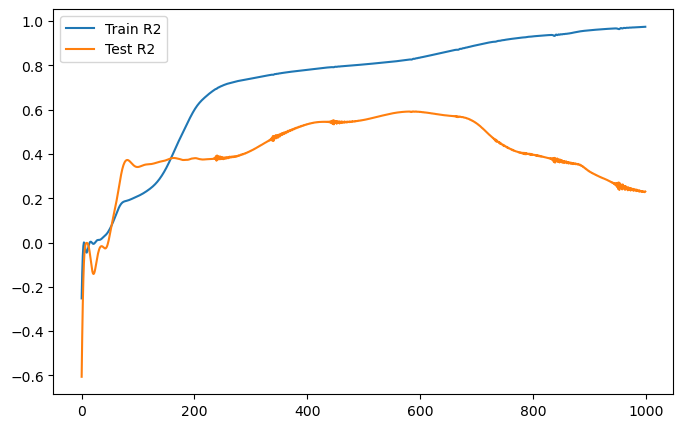

In [31]:
X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)

# Define the neural network
class DeepNN(nn.Module):
    def __init__(self, input_size = 5, output_size = 1):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 12)
        self.fc3 = nn.Linear(12, 16)
        self.out = nn.Linear(16, output_size)

        self.activation = nn.Sigmoid()  # Logistic sigmoid

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.out(x)
        return x

# Example instantiation
model = DeepNN()

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 1000
mse_train = []
mse_test  = []

mape_train = []
mape_test  = []

max_r2_test = []

r2_train = []
r2_test  = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    loss = criterion(y_train_pred, y_train)

    # Inverse from normalize
    y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
    y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
    y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
    y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

    # MAPE Calculation
    mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
    mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

    mape_train.append(mape_train_epoch)
    mape_test.append(mape_test_epoch)

    # Obtain Minimum MSE
    min_mape_train_x = np.argmin(mape_train)
    min_mape_train_y = np.min(mape_train)
    min_mape_test_x = np.argmin(mape_test)
    min_mape_test_y = np.min(mape_test)

    max_mape_train_y = np.max(mape_train)
    max_mape_test_y = np.max(mape_test)

    var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    r2_train.append(var_train)
    r2_test.append(var_test)
    max_r2_test_score = np.max(r2_test)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
        print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
        print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
        
        fig, axes = plt.subplots(1, 2, figsize = (8,3))
        axes[0].scatter(y_train_r, y_train_pred_r)
        axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
        axes[0].set_title("Training Data")
        axes[0].set_xlabel("Actual values")
        axes[0].set_ylabel("Predicted values")

        axes[1].scatter(y_test_r, y_test_pred_r)
        axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
        axes[1].set_title("Test Data")
        axes[1].set_xlabel("Actual values")
        axes[1].set_ylabel("Predicted values")
        
        f = plt.figure(figsize=(8,5))
        plt.plot(r2_train, label = "Train R2")
        plt.plot(r2_test,  label = "Test R2")
        # plt.plot(mape_train, label = "Train MAPE")
        # plt.plot(mape_test , label = "Test MAPE")
        # plt.ylabel("Mean Absolute Percentage Error (%)")
        # plt.xlabel("Epoch")
        # plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
        # plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
        #          bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
        #          bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
        plt.legend()

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()

In [29]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[ 1.8160,  1.7661,  0.2281,  0.3597,  2.5236],
        [ 0.3851,  2.1383, -1.5865, -1.9772, -0.8526],
        [-6.1412,  2.6564, -0.6319, -1.0043,  0.4669],
        [ 2.9568,  2.6580,  1.2574,  2.8662,  2.8868],
        [ 0.8840, -2.4113,  1.9509,  1.5277,  0.1524],
        [-0.6914, -2.8472,  1.3389, -2.6052, -0.9725],
        [ 3.2550, -2.2565,  1.0103,  1.7819,  0.8554],
        [ 1.3251,  0.1386,  3.0025,  0.1755,  0.7546]])
fc1.bias tensor([ 2.4967,  1.7443, -0.5600,  1.7746, -2.2485,  0.1717, -0.9685, -2.5577])
fc2.weight tensor([[-2.3071,  1.4945,  0.3911,  3.4076, -0.6447, -1.3014,  0.2311, -4.4935],
        [ 1.9539, -0.9540,  4.9348,  0.6031,  1.1776,  0.6825, -0.2733, -1.6242],
        [ 1.2450, -2.3945, -2.3128, -2.4696,  1.7238,  1.5630,  1.5721, -0.0797],
        [-0.4285, -3.0596, -2.2211, -3.1957,  2.0297,  1.6565,  1.6624,  0.1273],
        [ 1.8058, -1.7230, -1.9205, -2.6006,  2.8722,  3.0039,  1.9744, -2.4980],
        [-2.2555,  1.6993,  0.4417,  

Hidden Layer 1: 6 Hidden Layer 2: 9  Max R2:  0.5774079518094184
Hidden Layer 1: 6 Hidden Layer 2: 10  Max R2:  0.41508561794353005
Hidden Layer 1: 6 Hidden Layer 2: 11  Max R2:  0.6598950888363004
Hidden Layer 1: 6 Hidden Layer 2: 12  Max R2:  0.5255047415032572
Hidden Layer 1: 7 Hidden Layer 2: 9  Max R2:  0.4874937308024613
Hidden Layer 1: 7 Hidden Layer 2: 10  Max R2:  0.6062104117245894
Hidden Layer 1: 7 Hidden Layer 2: 11  Max R2:  0.5213571550089544
Hidden Layer 1: 7 Hidden Layer 2: 12  Max R2:  0.5687117990583709
Hidden Layer 1: 8 Hidden Layer 2: 9  Max R2:  0.5744534548650567
Hidden Layer 1: 8 Hidden Layer 2: 10  Max R2:  0.41906085887724687
Hidden Layer 1: 8 Hidden Layer 2: 11  Max R2:  0.50416245640115
Hidden Layer 1: 8 Hidden Layer 2: 12  Max R2:  0.5930065126148946
Hidden Layer 1: 9 Hidden Layer 2: 9  Max R2:  0.6455686861367584
Hidden Layer 1: 9 Hidden Layer 2: 10  Max R2:  0.5597626520121028
Hidden Layer 1: 9 Hidden Layer 2: 11  Max R2:  0.486472371767512
Hidden Layer 1:

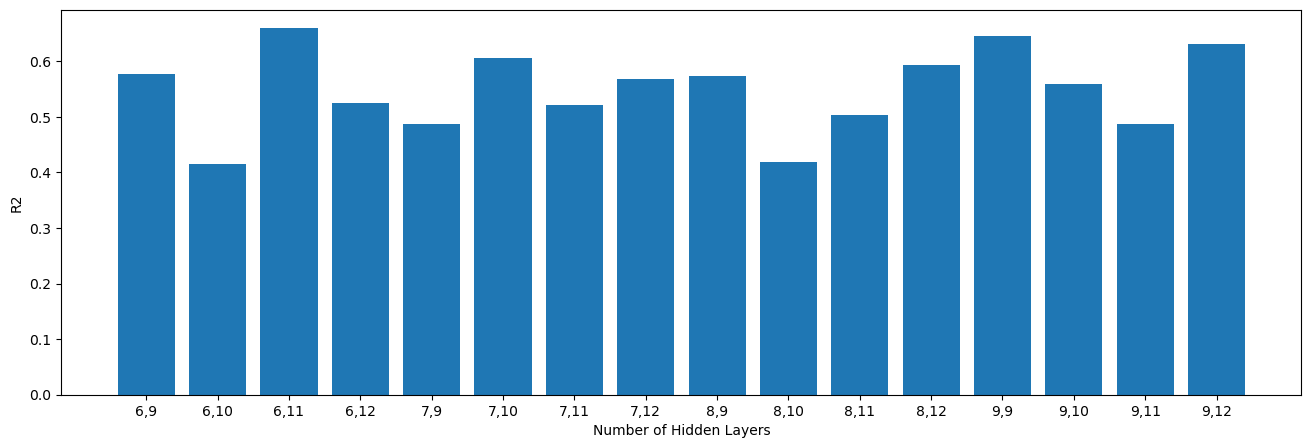

In [17]:
test4 = []
test5 = []

for x in range(6, 10,1):
    for y in range(9, 13,1):
        for z in range(14, 20, 1):
            result = SNN_ReLU(x, y, z, False)
            print("HL 1:", x, "HL 2:", y, "HL 3:", z," Max R2: ", result)
            hlayer_str = f"{x}" + "," + f"{y}" + f"{z}"
            test4.append(result)
            test5.append(hlayer_str)

f = plt.figure(figsize=(16,16))
x_bar = np.array(test4)
y_bar = np.array(test5)

plt.bar(x_bar,y_bar)
plt.xlabel("R2")
plt.ylabel("Number of Hidden Layers")
plt.show()

Epoch 100/1000
Train R²:  0.85785   Train MAPE:  5.699935927987099
Test R² :  0.52091   Test MAPE:   10.613373667001724


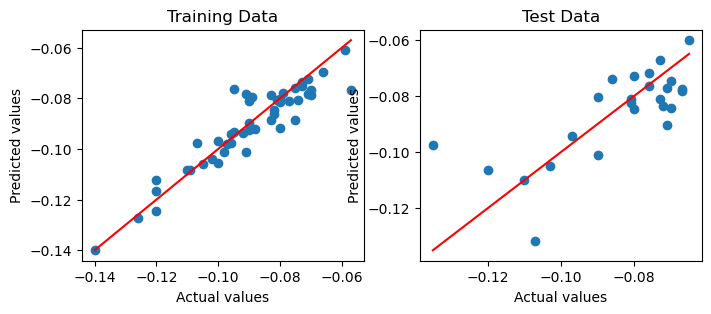

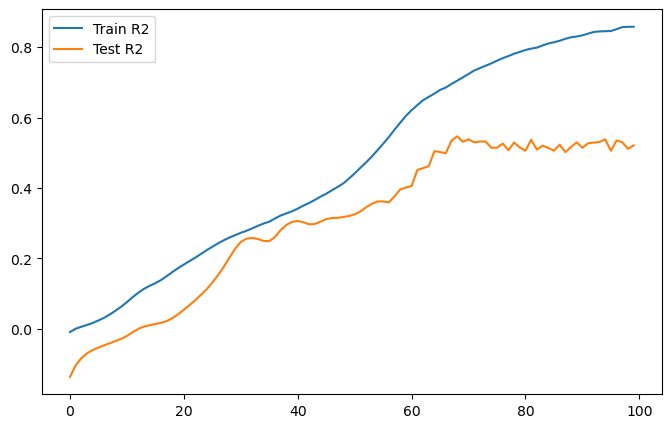

Epoch 200/1000
Train R²:  0.96033   Train MAPE:  2.575303800404072
Test R² :  0.40777   Test MAPE:   12.72922158241272


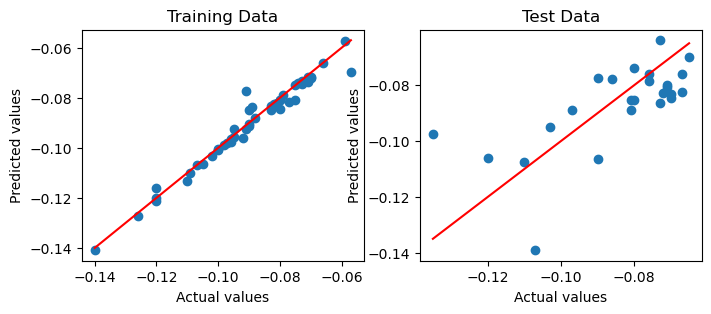

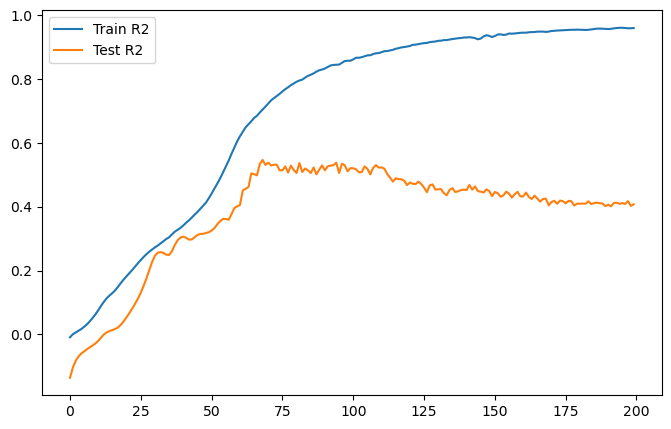

Epoch 300/1000
Train R²:  0.98012   Train MAPE:  1.898060366511345
Test R² :  0.37725   Test MAPE:   14.238764345645905


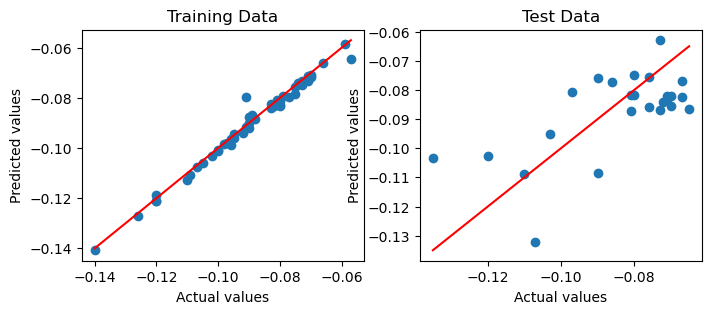

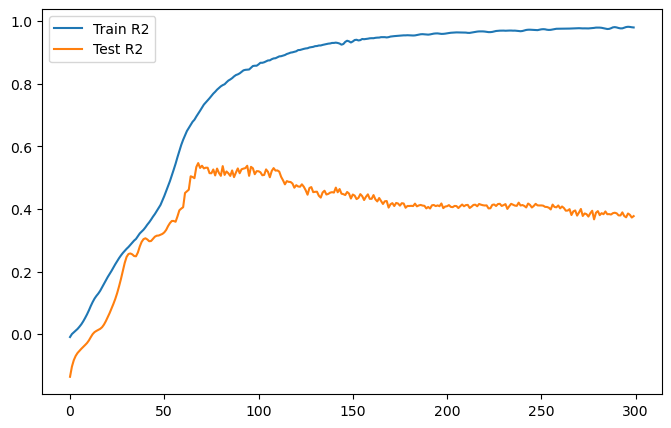

Epoch 400/1000
Train R²:  0.99130   Train MAPE:  1.0083186440169811
Test R² :  0.33570   Test MAPE:   14.632530510425568


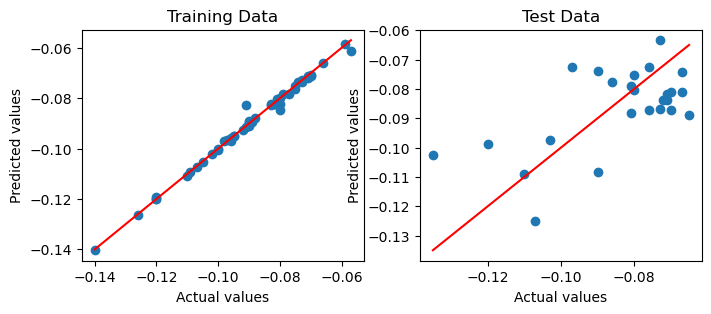

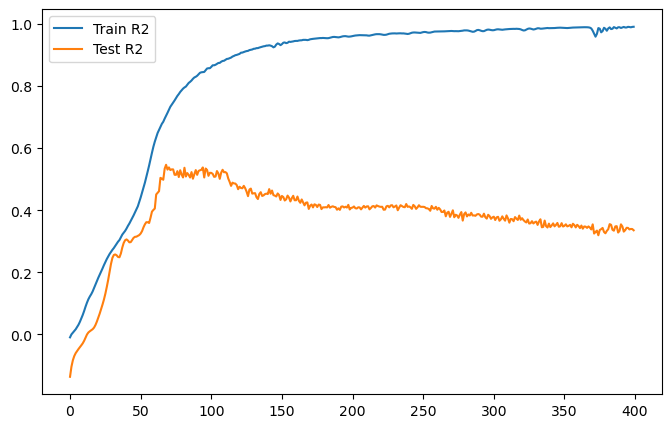

Epoch 500/1000
Train R²:  0.99509   Train MAPE:  0.7767936680465937
Test R² :  0.26703   Test MAPE:   15.581490099430084


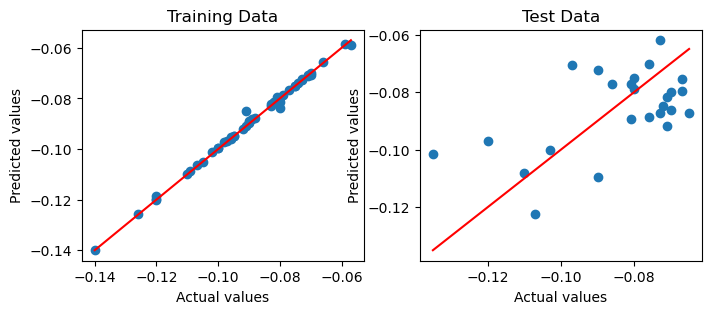

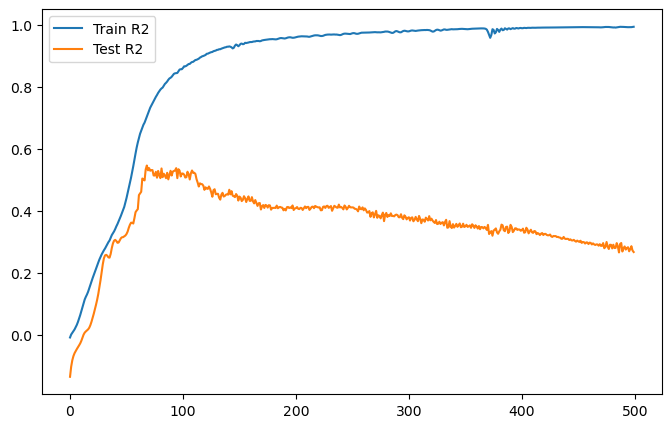

Epoch 600/1000
Train R²:  0.99765   Train MAPE:  0.5032540764659643
Test R² :  0.23564   Test MAPE:   15.969276428222656


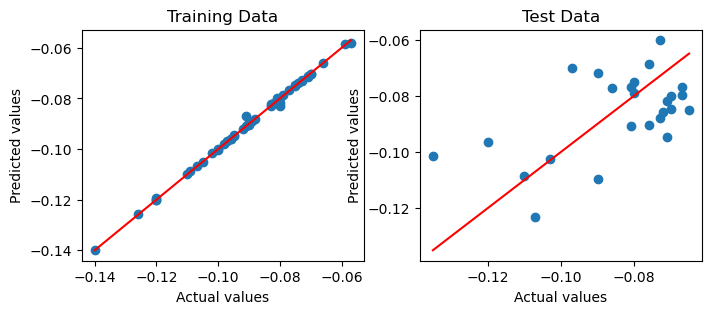

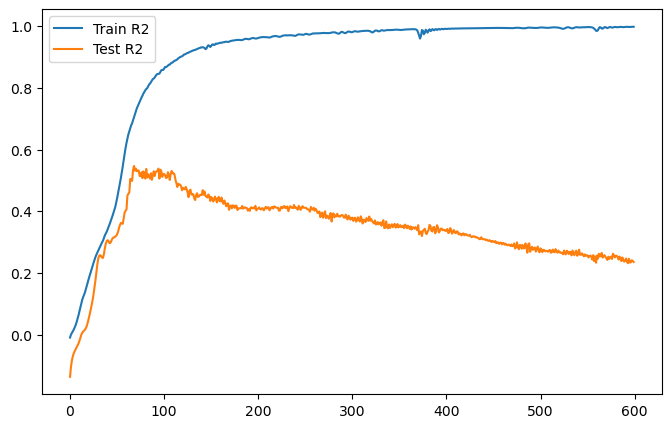

Epoch 700/1000
Train R²:  0.99884   Train MAPE:  0.4141861107200384
Test R² :  0.22856   Test MAPE:   16.13457053899765


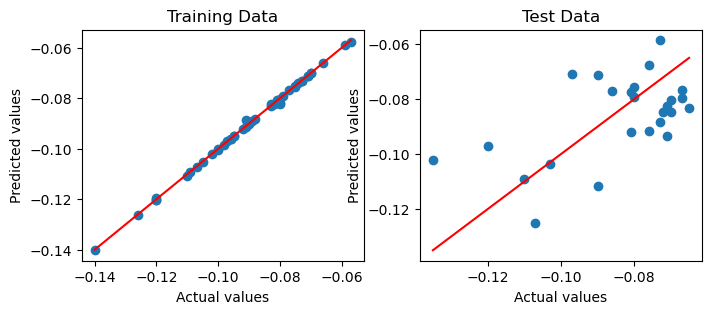

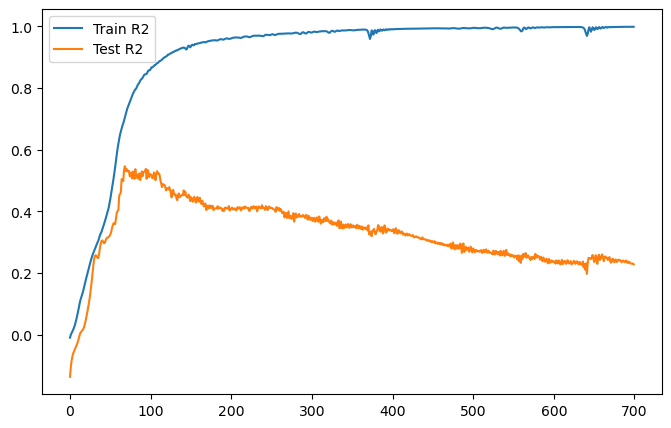

Epoch 800/1000
Train R²:  0.99948   Train MAPE:  0.2870109165087342
Test R² :  0.18502   Test MAPE:   16.615846753120422


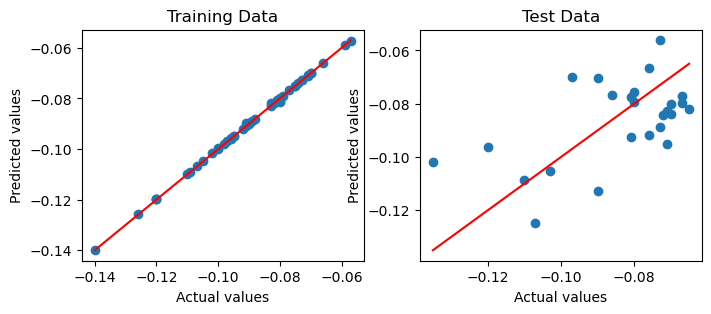

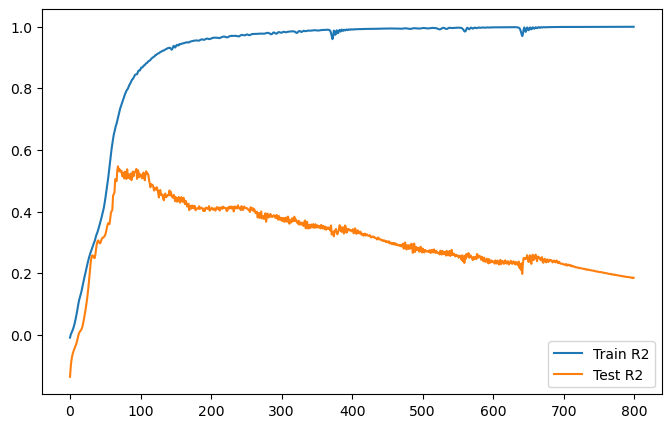

Epoch 900/1000
Train R²:  0.99969   Train MAPE:  0.17613909440115094
Test R² :  0.17598   Test MAPE:   16.750651597976685


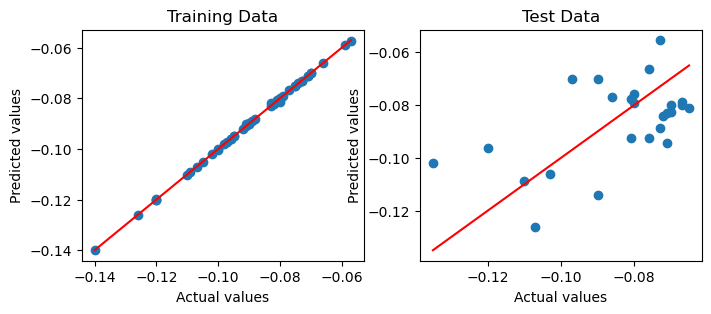

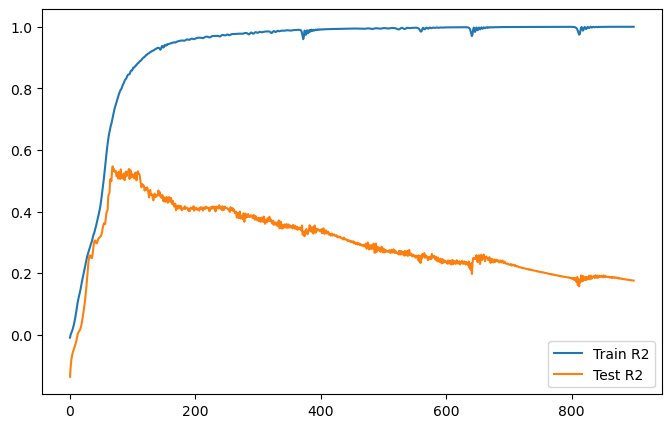

Epoch 1000/1000
Train R²:  0.99952   Train MAPE:  0.320953200571239
Test R² :  0.13561   Test MAPE:   16.892673075199127


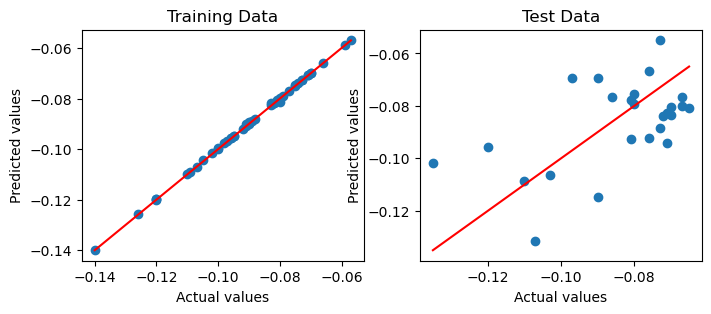

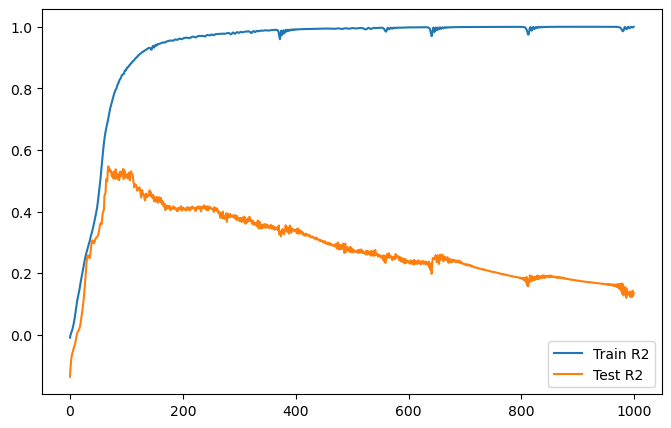

In [16]:
X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.33, random_state = 10)

# Define the neural network
class DeepNN(nn.Module):
    def __init__(self, input_size = 5, output_size = 1):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 12)
        self.fc3 = nn.Linear(12, 16)
        self.out = nn.Linear(16, output_size)

        self.activation = nn.ReLU()  # Logistic sigmoid

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.out(x)
        return x

# Example instantiation
model = DeepNN()

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01)

num_epochs = 1000
mse_train = []
mse_test  = []

mape_train = []
mape_test  = []

max_r2_test = []

r2_train = []
r2_test  = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    loss = criterion(y_train_pred, y_train)

    # Inverse from normalize
    y_train_r = scaler_y.inverse_transform(y_train.detach().numpy())
    y_train_pred_r = scaler_y.inverse_transform(y_train_pred.detach().numpy())
    y_test_r = scaler_y.inverse_transform(y_test.detach().numpy())
    y_test_pred_r = scaler_y.inverse_transform(y_test_pred.detach().numpy())

    # MAPE Calculation
    mape_train_epoch = mean_absolute_percentage_error(y_train_r, y_train_pred_r)*100
    mape_test_epoch = mean_absolute_percentage_error(y_test_r, y_test_pred_r)*100

    mape_train.append(mape_train_epoch)
    mape_test.append(mape_test_epoch)

    # Obtain Minimum MSE
    min_mape_train_x = np.argmin(mape_train)
    min_mape_train_y = np.min(mape_train)
    min_mape_test_x = np.argmin(mape_test)
    min_mape_test_y = np.min(mape_test)

    max_mape_train_y = np.max(mape_train)
    max_mape_test_y = np.max(mape_test)

    var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())
    r2_train.append(var_train)
    r2_test.append(var_test)
    max_r2_test_score = np.max(r2_test)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}") #, Training Loss: {loss.item():.4f}
        print("Train R²: ", "%.5f" % round(var_train, 5),"  Train MAPE: ", mape_train_epoch)
        print("Test R² : ", "%.5f" % round(var_test, 5),"  Test MAPE:  ", mape_test_epoch)
        
        fig, axes = plt.subplots(1, 2, figsize = (8,3))
        axes[0].scatter(y_train_r, y_train_pred_r)
        axes[0].plot([min(y_train_r), max(y_train_r)],[min(y_train_r), max(y_train_r)], color = 'r')
        axes[0].set_title("Training Data")
        axes[0].set_xlabel("Actual values")
        axes[0].set_ylabel("Predicted values")

        axes[1].scatter(y_test_r, y_test_pred_r)
        axes[1].plot([min(y_test_r), max(y_test_r)],[min(y_test_r), max(y_test_r)], color = 'r')
        axes[1].set_title("Test Data")
        axes[1].set_xlabel("Actual values")
        axes[1].set_ylabel("Predicted values")
        
        f = plt.figure(figsize=(8,5))
        plt.plot(r2_train, label = "Train R2")
        plt.plot(r2_test,  label = "Test R2")
        # plt.plot(mape_train, label = "Train MAPE")
        # plt.plot(mape_test , label = "Test MAPE")
        # plt.ylabel("Mean Absolute Percentage Error (%)")
        # plt.xlabel("Epoch")
        # plt.scatter(min_mape_train_x, min_mape_train_y,c= 'b', label='Minimum MAPE Train')
        # plt.scatter(min_mape_test_x, min_mape_test_y,c= 'r', label='Minimum MAPE Test')
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.95, f"Train MAPE: {round(min_mape_train_y, 2)}%, Epoch: {min_mape_train_x}", 
        #          bbox=dict(boxstyle="square,pad=0.3", fc="lightblue"))
        # plt.text(epoch * 0.2 , max_mape_train_y * 0.8, f"Test MAPE: {round(min_mape_test_y, 2)}%, Epoch: {min_mape_test_x}",
        #          bbox=dict(boxstyle="square,pad=0.3", fc="orange"))
        plt.legend()

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()